In [ ]:
import numpy as np 
import pandas as pd 
from PIL import Image 
import pathlib
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.applications import ResNet50

In [ ]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
IMG_DIM = (IMG_WIDTH, IMG_HEIGHT)
BATCH_SIZE = 8
IMG_DIR = '/content/drive/MyDrive/summer 2021/sra/research/data/'
TRAIN_DIR = '/content/drive/MyDrive/summer 2021/sra/research/data/train'
VAL_DIR = '/content/drive/MyDrive/summer 2021/sra/research/data/test'

In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Specify the values for all arguments to data_generator_with_aug.
data_generator_with_aug = ImageDataGenerator(preprocessing_function=preprocess_input,
                                              horizontal_flip = True,
                                              width_shift_range = 0.2,
                                              height_shift_range = 0.2
                                                )
            
data_generator_no_aug = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
train_generator = data_generator_with_aug.flow_from_directory(
                                        directory=TRAIN_DIR,
                                        target_size=IMG_DIM,
                                        batch_size=BATCH_SIZE,
                                        class_mode='categorical')

validation_generator = data_generator_no_aug.flow_from_directory(
                                        directory=VAL_DIR,
                                        target_size=IMG_DIM,batch_size=BATCH_SIZE,
                                        class_mode='categorical')

Found 5144 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
import tensorflow.keras as keras

resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_HEIGHT,IMG_WIDTH,3),pooling='max')

output = resnet.layers[-1].output
output = tf.keras.layers.Flatten()(output)
resnet = Model(resnet.input, output)

res_name = []
for layer in resnet.layers:
    res_name.append(layer.name)

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
res_name[-22:]

['conv5_block2_1_conv',
 'conv5_block2_1_bn',
 'conv5_block2_1_relu',
 'conv5_block2_2_conv',
 'conv5_block2_2_bn',
 'conv5_block2_2_relu',
 'conv5_block2_3_conv',
 'conv5_block2_3_bn',
 'conv5_block2_add',
 'conv5_block2_out',
 'conv5_block3_1_conv',
 'conv5_block3_1_bn',
 'conv5_block3_1_relu',
 'conv5_block3_2_conv',
 'conv5_block3_2_bn',
 'conv5_block3_2_relu',
 'conv5_block3_3_conv',
 'conv5_block3_3_bn',
 'conv5_block3_add',
 'conv5_block3_out',
 'max_pool',
 'flatten']

In [ ]:
set_trainable = False
for layer in resnet.layers:
    if layer.name in res_name[-22:]:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
resnet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout

num_classes = 3

model = Sequential()
model.add(resnet)
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 3075      
Total params: 26,738,563
Trainable params: 12,082,179
Non-trainable params: 14,656,384
___________________________________

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8,
                                              restore_best_weights=False
                                              )

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                   factor=0.2,
                                   patience=4,
                                   verbose=1,
                                   min_delta=5*1e-3,min_lr = 5*1e-7,
                                   )

In [ ]:
model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics=['accuracy',tfa.metrics.F1Score(num_classes=num_classes)])

In [ ]:
model.fit(
          train_generator,     
          epochs = 12,
          callbacks=[early_stop,reduce_lr],
          validation_data = validation_generator
          )

Epoch 1/24
643/643 [==============================] - ETA: 0s - loss: 1.2373 - accuracy: 0.8359 - f1_score: 0.7806

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


643/643 [==============================] - 2096s 3s/step - loss: 1.2373 - accuracy: 0.8359 - f1_score: 0.7806 - val_loss: 0.5049 - val_accuracy: 0.9107 - val_f1_score: 0.9143
Epoch 2/24
643/643 [==============================] - 213s 331ms/step - loss: 0.4033 - accuracy: 0.9125 - f1_score: 0.8956 - val_loss: 0.1910 - val_accuracy: 0.9557 - val_f1_score: 0.9509
Epoch 3/24
643/643 [==============================] - 214s 333ms/step - loss: 0.2302 - accuracy: 0.9327 - f1_score: 0.9229 - val_loss: 0.2033 - val_accuracy: 0.9425 - val_f1_score: 0.9467
Epoch 4/24
643/643 [==============================] - 215s 335ms/step - loss: 0.1932 - accuracy: 0.9438 - f1_score: 0.9360 - val_loss: 0.1474 - val_accuracy: 0.9581 - val_f1_score: 0.9561
Epoch 5/24
643/643 [==============================] - 216s 336ms/step - loss: 0.1877 - accuracy: 0.9469 - f1_score: 0.9397 - val_loss: 0.2147 - val_accuracy: 0.9418 - val_f1_score: 0.9429
Epoch 6/24
643/643 [==============================] - 215s 335ms/step - l

In [ ]:
def get_diagnostic_plot(model,name):
    training_loss = model.history.history[name]
    test_loss = model.history.history[f'val_{name}']

    # Create count of the number of epochs
    epoch_count = range(1, len(training_loss) + 1)

    # Visualize loss history
    plt.plot(epoch_count, training_loss, 'r--')
    plt.plot(epoch_count, test_loss, 'b-')
    plt.legend([f'Training {name}', f'Val {name}'])
    plt.xlabel('Epoch')
    plt.ylabel(name)

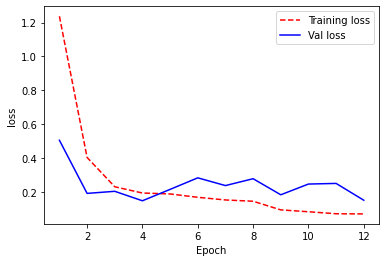

In [ ]:
get_diagnostic_plot(model,'loss')

In [ ]:
save_path = 'resnet50/'
tf.keras.models.save_model(model,save_path)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: resnet50_5/assets


In [ ]:
f1_score_history = model.history.history['f1_score']
f1_scores = [np.mean(item) for item in  f1_score_history]
f1_score_val_hist = model.history.history['val_f1_score']
f1_scores_val = [np.mean(item) for item in  f1_score_val_hist]

Text(0, 0.5, 'F1 Score')

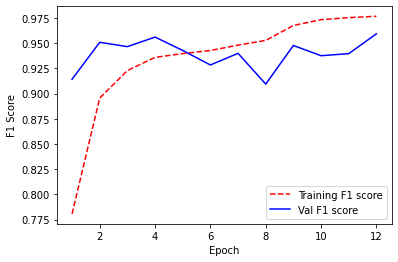

In [ ]:
training_loss = f1_scores
test_loss = f1_scores_val

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

    # Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training F1 score', 'Val F1 score'])
plt.xlabel('Epoch')
plt.ylabel('F1 Score')